## Pronóstico de series de tiempo de precipitación con autoencoder y DMD

In [11]:
import pandas as pd
import numpy as np

# Leer los datos desde el archivo CSV
# Supongamos que el archivo CSV tiene N filas (observaciones) y P columnas (estaciones)
data_df = pd.read_csv('../data/precipitation_test.csv')

# Convertir el DataFrame a un array de NumPy
data = data_df.values

# Verificar la forma de los datos
print(data.shape)  # Esto imprimirá (N, P), donde N es el número de observaciones y P es el número de estaciones.
# Guardar los datos en formato .npy
np.save('../data/precipitation_data.npy', data)

(1826, 30)


In [12]:
import xarray as xr
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pydmd import DMD

# Parámetros del espacio latente
latent_dim = 100 # Ajustar la dimensión del espacio latente

In [15]:
# Ruta del archivo (ya debe estar en la carpeta montada)
archivo = "../data/ERA5_daily_precipitation_1950_2022.nc"

# Abrir dataset
ds = xr.open_dataset(archivo)
ds

<xarray.Dataset> Size: 678MB
Dimensions:    (time: 26663, latitude: 155, longitude: 41)
Coordinates:
  * longitude  (longitude) float32 164B -76.0 -75.75 -75.5 ... -66.25 -66.0
  * latitude   (latitude) float32 620B -17.5 -17.75 -18.0 ... -55.5 -55.75 -56.0
  * time       (time) datetime64[ns] 213kB 1950-01-01T12:00:00 ... 2022-12-31...
Data variables:
    tp         (time, latitude, longitude) float32 678MB ...

In [16]:

ds = ds.sel(time=slice("2000-01-01", "2022-12-31")) # Filtra desde 2000 a 2022
ds = ds.sel(latitude=slice(-30, -40)) # Filtra zona central
ds

<xarray.Dataset> Size: 57MB
Dimensions:    (time: 8401, latitude: 41, longitude: 41)
Coordinates:
  * longitude  (longitude) float32 164B -76.0 -75.75 -75.5 ... -66.25 -66.0
  * latitude   (latitude) float32 164B -30.0 -30.25 -30.5 ... -39.5 -39.75 -40.0
  * time       (time) datetime64[ns] 67kB 2000-01-01T12:00:00 ... 2022-12-31T...
Data variables:
    tp         (time, latitude, longitude) float32 56MB ...

In [3]:
# 1. Cargar y preparar los datos
X = np.load('../data/precipitation_data.npy')  # [samples, stations]

# Normalizar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Definir el número de características (dimensión multivariada)
n_features = X.shape[1] # Dimensión de las series multivariadas
X_scaled = X_scaled[:, :n_features]  # Asegurarse de que X_scaled tiene m=150 series

# Reshape para el autoencoder
X_scaled = X_scaled.reshape(-1, 1, n_features)

In [ ]:
# 2. Definir el Autoencoder
timesteps = X_scaled.shape[1]

input_layer = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu', return_sequences=False)(input_layer)  # Encoder
encoded = Dense(latent_dim, activation='relu')(encoded)  # Latent space
decoded = Dense(64, activation='relu')(encoded)  # Decoder
decoded = RepeatVector(timesteps)(decoded)
decoded = LSTM(n_features, activation='sigmoid', return_sequences=True)(decoded)  # Output layer

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=1, shuffle=True)

2025-10-04 21:31:07.584053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
[lstm.py:591 -             __init__() ] Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
2025-10-04 21:31:07.590346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 21:31:07.590394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-04 21:31:07.593626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could

[lstm.py:591 -             __init__() ] Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


Epoch 1/50


2025-10-04 21:31:09.803522: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f12b53519b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-04 21:31:09.803547: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-10-04 21:31:09.806799: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-04 21:31:09.820547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-10-04 21:31:09.883714: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1826/1826 [==============================] - 11s 5ms/step - loss: 0.0062
Epoch 2/50
1826/1826 [==============================] - 11s 6ms/step - loss: 0.0040
Epoch 3/50
1826/1826 [==============================] - 9s 5ms/step - loss: 0.0031
Epoch 4/50
1826/1826 [==============================] - 9s 5ms/step - loss: 0.0019
Epoch 5/50
1826/1826 [==============================] - 9s 5ms/step - loss: 0.0018
Epoch 6/50
1826/1826 [==============================] - 10s 5ms/step - loss: 0.0016
Epoch 7/50
1826/1826 [==============================] - 8s 4ms/step - loss: 0.0018
Epoch 8/50
1826/1826 [==============================] - 8s 4ms/step - loss: 0.0016
Epoch 9/50
1826/1826 [==============================] - 10s 6ms/step - loss: 0.0017
Epoch 10/50
1826/1826 [==============================] - 9s 5ms/step - loss: 0.0015
Epoch 11/50
1826/1826 [==============================] - 8s 5ms/step - loss: 0.0015
Epoch 12/50
1826/1826 [==============================] - 8s 5ms/step - loss: 0.0020
Epoch 13

In [ ]:
#Guardar los pesos del autoencoder
autoencoder.save_weights('../models/autoencoder_v2.weights.h5')

58/58 [==============================] - 0s 2ms/step


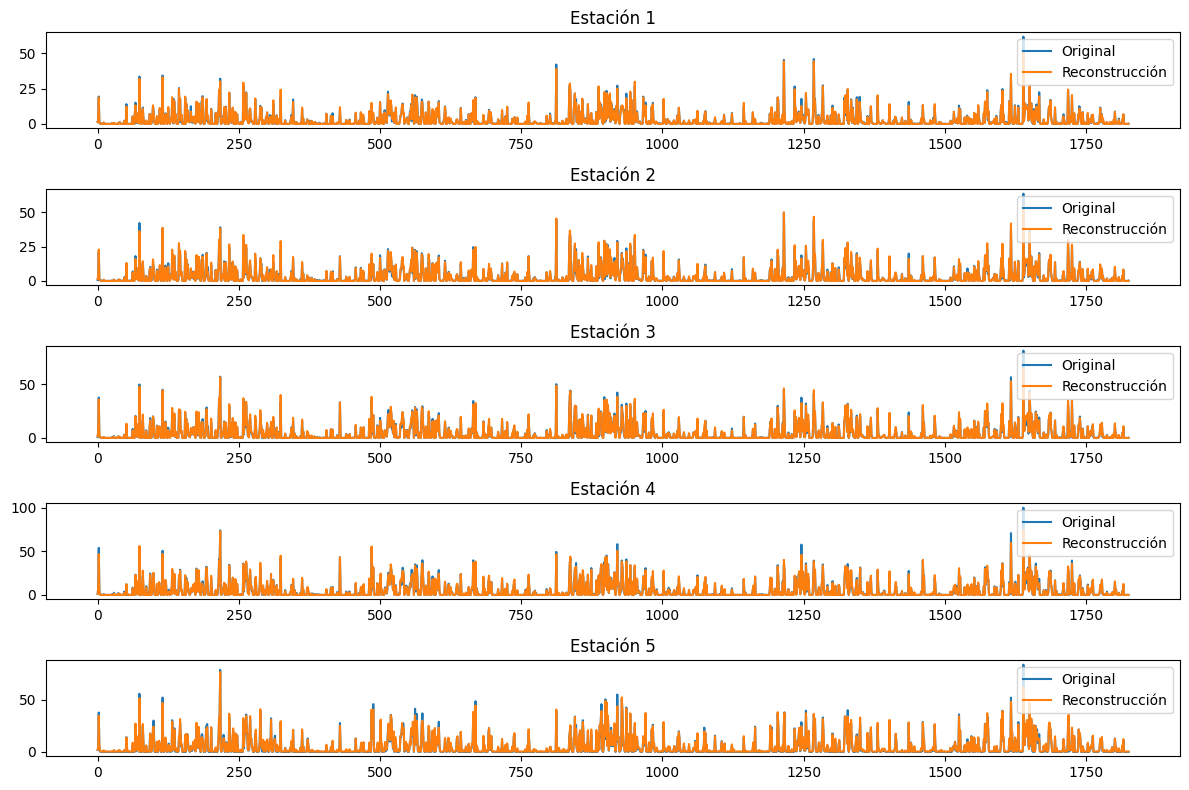

In [6]:
# 6. Verificar las reconstrucciones del autoencoder
X_reconstructed_new = autoencoder.predict(X_scaled)

# Revertir el reshape y la normalización
X_reconstructed_new = X_reconstructed_new.reshape(-1, n_features)
X_scaled_ = X_scaled.reshape(-1, n_features)
X_reconstructed_new = scaler.inverse_transform(X_reconstructed_new)
X_scaled_ = scaler.inverse_transform(X_scaled_)

# 6.1. Graficar las series originales y reconstruidas para comparar

# Definir el número de estaciones a mostrar en las gráficas
num_stations_to_plot = 5  # Cambiar este valor para regular el número de estaciones que se muestran

plt.figure(figsize=(12, 8))
for i in range(min(n_features, num_stations_to_plot)):
    plt.subplot(num_stations_to_plot, 1, i + 1)
    plt.plot(X_scaled_[:, i], label='Original')
    plt.plot(X_reconstructed_new[:, i], label='Reconstrucción')
    plt.title(f'Estación {i + 1}')
    plt.legend()
plt.tight_layout()
plt.show()

 1/58 [..............................] - ETA: 0s

58/58 [==============================] - 0s 2ms/step


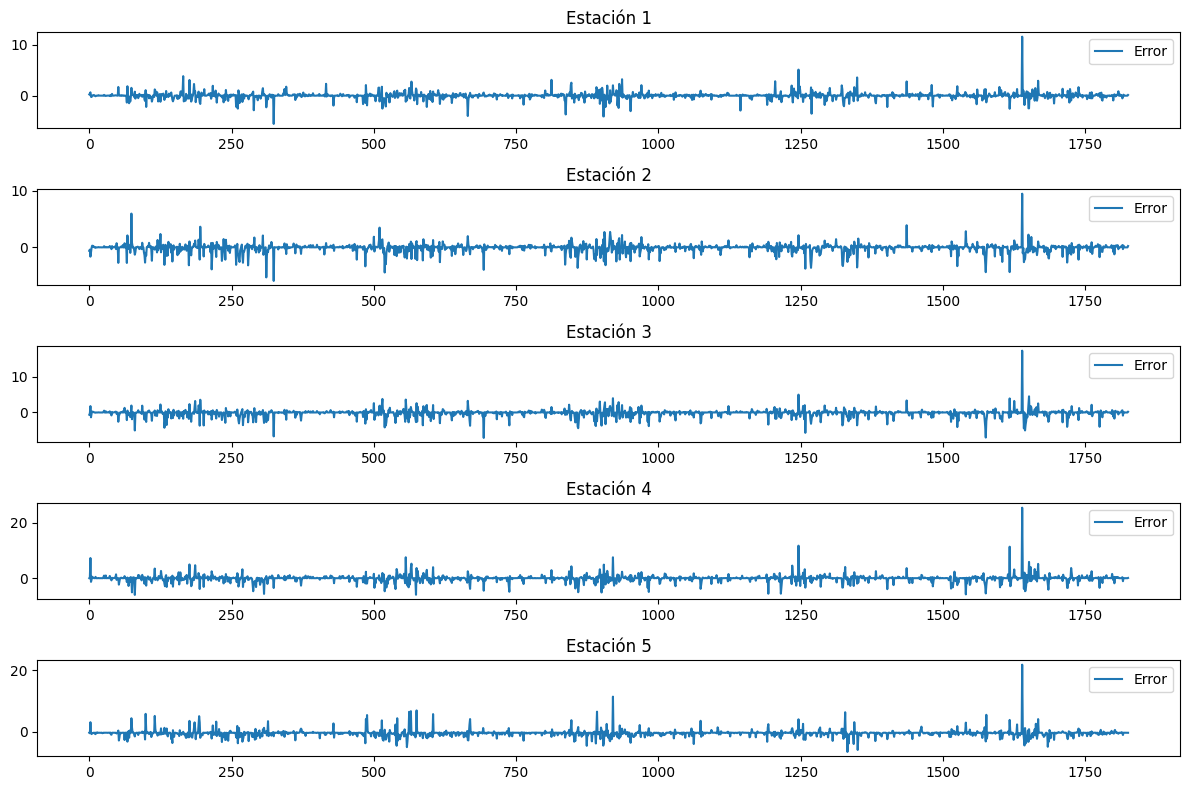

In [7]:
# 6. Verificar las reconstrucciones del autoencoder
X_reconstructed_new = autoencoder.predict(X_scaled)

# Revertir el reshape y la normalización
X_reconstructed_new = X_reconstructed_new.reshape(-1, n_features)
X_scaled_ = X_scaled.reshape(-1, n_features)
X_reconstructed_new = scaler.inverse_transform(X_reconstructed_new)
X_scaled_ = scaler.inverse_transform(X_scaled_)

# 6.1. Graficar las series originales y reconstruidas para comparar

# Definir el número de estaciones a mostrar en las gráficas
num_stations_to_plot = 5  # Cambiar este valor para regular el número de estaciones que se muestran

plt.figure(figsize=(12, 8))
for i in range(min(n_features, num_stations_to_plot)):
    plt.subplot(num_stations_to_plot, 1, i + 1)
    plt.plot(X_scaled_[:, i] - X_reconstructed_new[:, i], label='Error')
    plt.title(f'Estación {i + 1}')
    plt.legend()
plt.tight_layout()
plt.show()

58/58 [==============================] - 0s 2ms/step


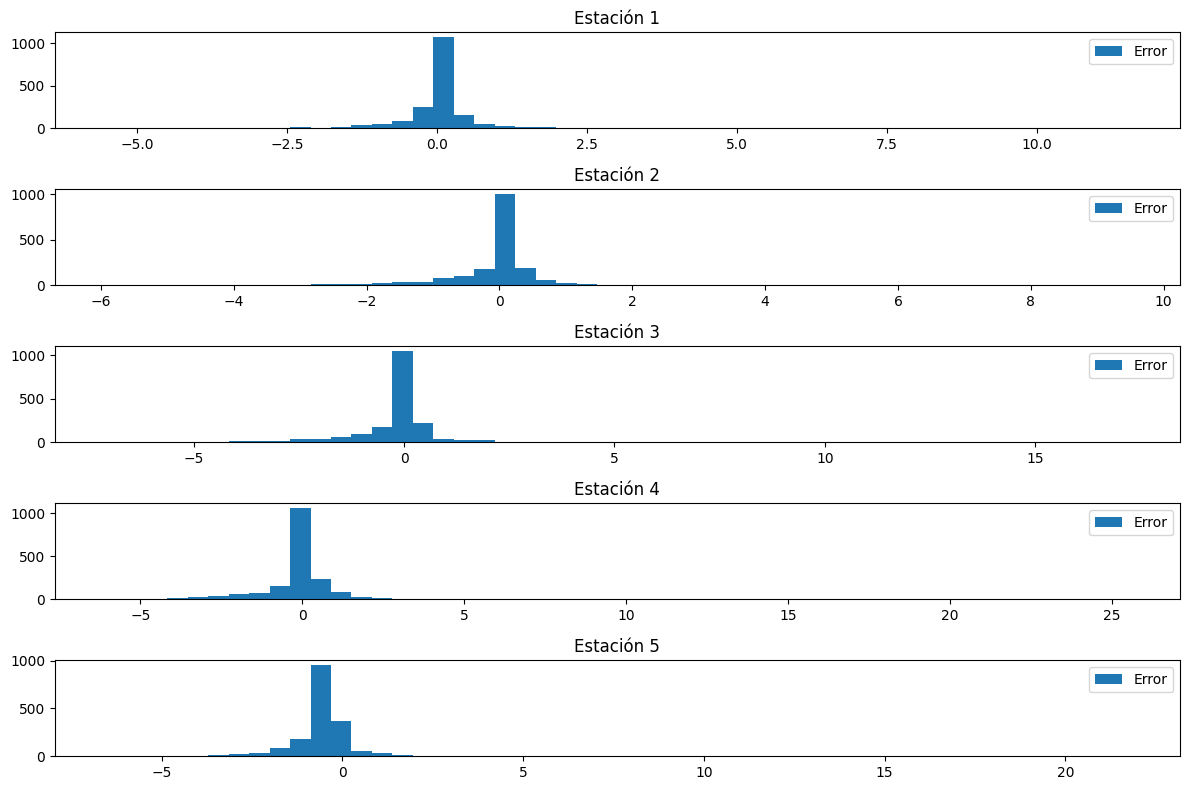

In [8]:
# 6. Verificar las reconstrucciones del autoencoder
X_reconstructed_new = autoencoder.predict(X_scaled)

# Revertir el reshape y la normalización
X_reconstructed_new = X_reconstructed_new.reshape(-1, n_features)
X_scaled_ = X_scaled.reshape(-1, n_features)
X_reconstructed_new = scaler.inverse_transform(X_reconstructed_new)
X_scaled_ = scaler.inverse_transform(X_scaled_)

# 6.1. Graficar las series originales y reconstruidas para comparar

# Definir el número de estaciones a mostrar en las gráficas
num_stations_to_plot = 5  # Cambiar este valor para regular el número de estaciones que se muestran

plt.figure(figsize=(12, 8))
for i in range(min(n_features, num_stations_to_plot)):
    plt.subplot(num_stations_to_plot, 1, i + 1)
    plt.hist(X_scaled_[:, i] - X_reconstructed_new[:, i], label='Error', bins=50)
    plt.title(f'Estación {i + 1}')
    plt.legend()
plt.tight_layout()
plt.show()